In [1]:
import glob
from collections import OrderedDict

In [2]:
data_path = 'G:\Sanit_Horizontal\Batteries\DataSets\LG18650\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020'

# Functions

__Function for seprating the required cycles__

In [3]:
def contain_list(file_name,list_name):
    
    dum = []
    
    for s in list_name:
        
        if s in file_name:
            
            dum = file_name
            break     
        
    return(dum)

__Function for getting only the required files__

In [4]:
def csv_list_find(data_path,folder,cycle):
    
    
    csv_file_path_list = []
    csv_file_list = []
    our_files = []
    folder = folder

    d = os.path.join(data_path,folder)
    
    if os.path.isdir(d):

            # csv files in the path
            csv_list = glob.glob(d + "/*.csv")
            
            for i in range(len(csv_list)):

                if (contain_list(csv_list[i],cycle)!= []):
                    
                    our_files.append(contain_list(csv_list[i],cycle))
        
    return our_files

__Function for getting the filtered list__

In [5]:
def filtered_file_list(csv_files,charge_cycle_files,test_drive_cycles):

    file_path = {}

    for file in csv_files:

        df = pd.read_csv(file, header=[25,26], index_col=0, parse_dates=True,nrows=26)
        file_path[str(df.first_valid_index())] = file

    od = OrderedDict(sorted(file_path.items()))
    filtered = od.copy()


    # File rearrange code
    
    is_previous_charge = False
    is_previous_discharge = False

    for key, value in od.items():

        if not is_previous_discharge and any(substring in value for substring in test_drive_cycles):
            is_previous_discharge = True 
            is_previous_charge = False

        elif not is_previous_charge and any(substring in value for substring in charge_cycle_files):
            if not is_previous_charge and not is_previous_discharge:
                filtered.pop(key)
            is_previous_charge = True
            is_previous_discharge = False

        elif is_previous_discharge and any(substring in value for substring in test_drive_cycles):
            filtered.pop(key)

        elif is_previous_charge and any(substring in value for substring in charge_cycle_files):
            filtered.pop(key)
            
    return (list(filtered.values()))

# Main Code

## User Inputs

In [6]:
# CSV files have the string mentioned in their name

charge_cycle_files = ['Charge']

train_temps = ['n10degC', '0degC', '10degC', '25degC']
train_drive_cycles = ['Mixed']

test_temps = ['n10degC', '0degC', '10degC', '25degC']
test_temps = ['25degC']
test_drive_cycles = ['UDDS', 'HWFET', 'LA92', 'US06']

vi_averages = True
# resample_freq = 1
resample_1hz = True

## CSV file List Code

In [7]:
# Get all CSV files
csv_files = csv_list_find(data_path,test_temps[0],(test_drive_cycles + charge_cycle_files))

# Filtering only the required files
filtered_file_path = filtered_file_list(csv_files,charge_cycle_files,test_drive_cycles)

In [8]:
filtered_file_path

['G:\\Sanit_Horizontal\\Batteries\\DataSets\\LG18650\\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\\25degC\\551_UDDS.csv',
 'G:\\Sanit_Horizontal\\Batteries\\DataSets\\LG18650\\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\\25degC\\551_Charge3.csv',
 'G:\\Sanit_Horizontal\\Batteries\\DataSets\\LG18650\\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\\25degC\\551_HWFET.csv',
 'G:\\Sanit_Horizontal\\Batteries\\DataSets\\LG18650\\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\\25degC\\551_Charge4.csv',
 'G:\\Sanit_Horizontal\\Batteries\\DataSets\\LG18650\\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\\25degC\\551_LA92.csv',
 'G:\\Sanit_Horizontal\\Batteries\\DataSets\\LG18650\\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\\25degC\\551_Charge5.csv',
 'G:\\Sanit_Horizontal\\Batteries\\DataSets\\LG18650\\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\\25degC\\551_US06.csv',
 'G:\\Sanit_Horizontal\\Batteries\\DataSets\\LG18650\\LG_HG2_Original_Dataset_Mc

## Normalization Code

In [9]:
for path in filtered_file_path:
    
    cycle = pd.read_csv(path, header=[25,26], index_col=0, parse_dates=True)
    cycle.drop(cycle.columns[-1],axis=1,inplace=True)
    cycle.columns = cycle.columns.droplevel(-1)

    # leave out 'PAU' rows from the cycle
    options = ['CHA', 'DCH', 'TABLE']
    cycle = cycle[cycle['Status'].isin(options)]

    # calculate 'Power'
    cycle['Power'] = cycle['Voltage'] * cycle['Current']

    # calculate SOC Percentage + downsample discharge cycles, upsample charge cycles
    # - DISCHARGE FILES
    if any(substring in path for substring in test_drive_cycles):
        max_discharge = abs(min(cycle['Capacity']))
        cycle['SoC Percentage'] = (cycle['Capacity'] + max_discharge)/max_discharge


        if resample_1hz:
            cycle = cycle.resample('1S').first()

    # - CHARGE FILES
    elif any(substring in path for substring in charge_cycle_files):
        max_charge = abs(max(cycle['Capacity']))
        cycle['SoC Percentage'] = (cycle['Capacity'])/max_charge

        if resample_1hz:
            cycle = cycle[~cycle.index.duplicated(keep='first')]
            cycle = cycle.resample('1S').ffill()


    # select required features
    parameters = cycle[['Voltage', 'Current', 'Temperature', 'Power', 'SoC Percentage']].copy()

    # calculate 'Voltage', 'Current' and 'Power' averages
    # 500 second rolling window which translates to rougly 500 data points for resampled data and 5000 for raw data
    rolling_window = 5000
    if vi_averages and resample_1hz:
      rolling_window = int(rolling_window / 10)

    if vi_averages:
      parameters['Voltage Average'] = parameters['Voltage'].rolling(rolling_window).mean()
      parameters['Current Average'] = parameters['Current'].rolling(rolling_window).mean()
      parameters['Power Average'] = parameters['Power'].rolling(rolling_window).mean()

    parameters.dropna(inplace = True)
    parameters.reset_index(drop=True, inplace=True)
    
    # merge datasets
    try:
        merged = pd.concat([merged, parameters], ignore_index=True)
    except:
        merged = parameters.copy()
        
        
# scale (normalize) the dataset using mean normalization
merged_norm = (merged-merged.mean())/merged.std()
# min-max normalization
# merged_norm = (merged - merged.min())/(merged.max() - merged.min())

In [10]:
merged_norm.head()

Time Stamp,Voltage,Current,Temperature,Power,SoC Percentage,Voltage Average,Current Average,Power Average
0,1.157878,1.052095,-0.709327,1.160314,1.261507,1.001369,-0.541398,-0.610492
1,1.177307,1.130004,-0.709327,1.250295,1.262495,1.001309,-0.537922,-0.606666
2,1.146102,0.930558,-0.709327,1.021740,1.263327,1.001192,-0.534997,-0.603454
3,1.095432,0.640739,-0.709327,0.691085,1.263899,1.000967,-0.532957,-0.601219
4,1.071880,0.511931,-0.709327,0.544820,1.264354,1.000693,-0.531310,-0.599418


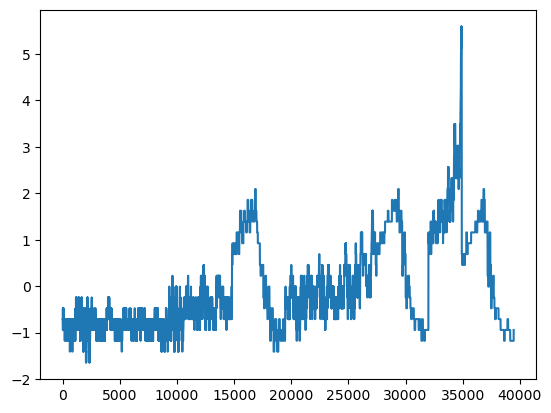

In [11]:
plt.plot(merged_norm['Temperature'])